In [36]:
#!/usr/bin/python3
from sklearn.svm import OneClassSVM
import pandas as pd
import feather
from sklearn.model_selection import train_test_split

import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import pickle
np.random.seed(500)
import time
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler

In [ ]:
pickle_in = open("df_yelpzip.pickle","rb")
df = pickle.load(pickle_in)

In [4]:
df

,user_id,prod_id,date,rating,label,review_content,word_count,tokenized,text_final
0,923,0,2014-12-08,3.0,-1,the food at snack is a selection of popular gr...,42,"[the, food, at, snack, is, a, selection, of, p...","['food', 'snack', 'selection', 'popular', 'gre..."
1,923,19,2014-01-14,5.0,-1,the restaurant is on the ground floor of a typ...,95,"[the, restaurant, is, on, the, ground, floor, ...","['restaurant', 'ground', 'floor', 'typical', '..."
2,923,63,2014-11-13,4.0,-1,i really enjoyed brunch at jane. the ambiance ...,35,"[i, really, enjoyed, brunch, at, jane, ., the,...","['really', 'enjoy', 'brunch', 'jane', 'ambianc..."
3,923,100,2014-03-05,4.0,-1,clinton street baking is a super popular baker...,65,"[clinton, street, baking, is, a, super, popula...","['clinton', 'street', 'baking', 'super', 'popu..."
4,923,103,2014-07-28,5.0,-1,thiru has wonderful personality. he has a very...,18,"[thiru, has, wonderful, personality, ., he, ha...","['thiru', 'wonderful', 'personality', 'loyal',..."
...,...,...,...,...,...,...,...,...,...
181350,161143,349,2014-02-19,5.0,1,get the fried brussel sprouts. get the emily p...,55,"[get, the, fried, brussel, sprouts, ., get, th...","['get', 'fried', 'brussel', 'sprout', 'get', '..."
181351,161144,349,2014-02-11,5.0,1,the food was perfect. the wine was perfect. th...,78,"[the, food, was, perfect, ., the, wine, was, p...","['food', 'perfect', 'wine', 'perfect', 'atmosp..."
181352,161145,349,2014-02-09,5.0,1,came here for sunday brunch. everything we tas...,45,"[came, here, for, sunday, brunch, ., everythin...","['come', 'sunday', 'brunch', 'everything', 'ta..."
181353,161146,349,2014-02-06,5.0,1,"i'm very spoiled with pizza. really, i have tr...",280,"[i, 'm, very, spoiled, with, pizza, ., really,...","['spoil', 'pizza', 'really', 'try', 'lucali', ..."


In [23]:
pos=0 
neg = 0

for x in df['label']:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos, 'total', neg+pos,'percent deceptive', neg*100.0/(neg+pos)) 

negative:  40832  positive: 263508 total 304340 percent deceptive 13.416573569034632


In [3]:
# file_path = '/home/parallels/KTH/II2202/Data/YelpZip/database_yelpzip.feather'
# df = pd.read_feather(file_path, columns=None, use_threads=True)

In [4]:
df.dtypes

user_id             int32
prod_id             int32
date               object
rating            float64
label               int32
review_content     object
word_count          int32
dtype: object

In [5]:
df

,user_id,prod_id,date,rating,label,review_content,word_count
0,5044,0,2014-11-16,1.0,-1,"Drinks were bad, the hot chocolate was watered...",36
1,5045,0,2014-09-08,1.0,-1,This was the worst experience I've ever had a ...,260
2,5046,0,2013-10-06,3.0,-1,This is located on the site of the old Spruce ...,50
3,5046,376,2013-11-02,3.0,-1,I am becoming frustrated with yelp. I placed ...,62
4,5047,0,2014-11-30,5.0,-1,I enjoyed coffee and breakfast twice at Toast ...,234
...,...,...,...,...,...,...,...
304335,265232,5041,2014-12-13,5.0,-1,Great local bar with a cozy atmosphere (firepl...,38
304336,265233,5041,2014-12-11,5.0,-1,This cozy Brooklyn restaurant is for sure a wi...,90
304337,265234,5041,2014-12-02,5.0,-1,I wanna let you in on one of Brooklyn's best k...,229
304338,265235,5041,2014-10-30,5.0,-1,BIJANS is the BEST!!! I love it here. First le...,20735


In [6]:
df.describe()

,user_id,prod_id,rating,label,word_count
count,304340.000000,304340.000000,304340.000000,304340.000000,304340.000000
mean,90112.485523,2612.333233,3.924371,0.731669,240.906135
std,74262.444989,1456.788655,1.145761,0.681662,2862.792327
min,5044.000000,0.000000,1.000000,-1.000000,1.000000
25%,25276.000000,1398.000000,3.000000,1.000000,45.000000
50%,67841.500000,2711.000000,4.000000,1.000000,87.000000
75%,143742.000000,3846.000000,5.000000,1.000000,155.000000
max,265320.000000,5043.000000,5.000000,1.000000,267753.000000


In [7]:
df.iloc[390,:]

user_id                                                        5114
prod_id                                                        3229
date                                                     2011-09-13
rating                                                            3
label                                                             1
review_content    Good service. Average Bloody Mary's..really, n...
word_count                                                       30
Name: 390, dtype: object

In [8]:
# # Step - a : Remove blank rows if any.
# df['review_content'].dropna(inplace=True)

In [9]:
# # Step - b : Change all the text to lower case
# df['review_content'] = [entry.lower() for entry in df['review_content']]

In [10]:
# # Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
# # tokenized = []
# # for index,entry in enumerate(genuine['review_content']): 
# #     genuine.loc[index,'tokenized'] = [word_tokenize(entry)]
# #     percent = index/len(genuine)*100
# #     print('percent done [%d%%]\r'%percent, end="")
# df['tokenized']= [word_tokenize(entry) for entry in df['review_content']]

In [11]:
df

,user_id,prod_id,date,rating,label,review_content,word_count,tokenized
0,5044,0,2014-11-16,1.0,-1,"drinks were bad, the hot chocolate was watered...",36,"[drinks, were, bad, ,, the, hot, chocolate, wa..."
1,5045,0,2014-09-08,1.0,-1,this was the worst experience i've ever had a ...,260,"[this, was, the, worst, experience, i, 've, ev..."
2,5046,0,2013-10-06,3.0,-1,this is located on the site of the old spruce ...,50,"[this, is, located, on, the, site, of, the, ol..."
3,5046,376,2013-11-02,3.0,-1,i am becoming frustrated with yelp. i placed ...,62,"[i, am, becoming, frustrated, with, yelp, ., i..."
4,5047,0,2014-11-30,5.0,-1,i enjoyed coffee and breakfast twice at toast ...,234,"[i, enjoyed, coffee, and, breakfast, twice, at..."
...,...,...,...,...,...,...,...,...
304335,265232,5041,2014-12-13,5.0,-1,great local bar with a cozy atmosphere (firepl...,38,"[great, local, bar, with, a, cozy, atmosphere,..."
304336,265233,5041,2014-12-11,5.0,-1,this cozy brooklyn restaurant is for sure a wi...,90,"[this, cozy, brooklyn, restaurant, is, for, su..."
304337,265234,5041,2014-12-02,5.0,-1,i wanna let you in on one of brooklyn's best k...,229,"[i, wan, na, let, you, in, on, one, of, brookl..."
304338,265235,5041,2014-10-30,5.0,-1,bijans is the best!!! i love it here. first le...,20735,"[bijans, is, the, best, !, !, !, i, love, it, ..."


In [14]:
# # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
# tag_map = defaultdict(lambda : wn.NOUN)
# tag_map['J'] = wn.ADJ
# tag_map['V'] = wn.VERB
# tag_map['R'] = wn.ADV
# final_text = [None]*len(df['tokenized'])
# for index,entry in enumerate(df['tokenized']):
#     # Declaring Empty List to store the words that follow the rules for this step
#     Final_words = []
#     # Initializing WordNetLemmatizer()
#     percent = float(index/len(df['tokenized'])*100)

#     print('percent done [%f%%]\r'%percent, end="")
#     word_Lemmatized = WordNetLemmatizer()
#     # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
#     for word, tag in pos_tag(entry):
#         # Below condition is to check for Stop words and consider only alphabets
#         if word not in stopwords.words('english') and word.isalpha():
#             word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
#             Final_words.append(word_Final)
#     # The final processed set of words for each iteration will be stored in 'text_final'
#     df.loc[index,'text_final'] = str(Final_words)
#     final_text[index]=(Final_words)

In [15]:
df

,user_id,prod_id,date,rating,label,review_content,word_count,tokenized,text_final
0,5044,0,2014-11-16,1.0,-1,"drinks were bad, the hot chocolate was watered...",36,"[drinks, were, bad, ,, the, hot, chocolate, wa...","['drink', 'bad', 'hot', 'chocolate', 'water', ..."
1,5045,0,2014-09-08,1.0,-1,this was the worst experience i've ever had a ...,260,"[this, was, the, worst, experience, i, 've, ev...","['bad', 'experience', 'ever', 'casual', 'fare'..."
2,5046,0,2013-10-06,3.0,-1,this is located on the site of the old spruce ...,50,"[this, is, located, on, the, site, of, the, ol...","['locate', 'site', 'old', 'spruce', 'video', '..."
3,5046,376,2013-11-02,3.0,-1,i am becoming frustrated with yelp. i placed ...,62,"[i, am, becoming, frustrated, with, yelp, ., i...","['become', 'frustrate', 'yelp', 'place', 'revi..."
4,5047,0,2014-11-30,5.0,-1,i enjoyed coffee and breakfast twice at toast ...,234,"[i, enjoyed, coffee, and, breakfast, twice, at...","['enjoy', 'coffee', 'breakfast', 'twice', 'toa..."
...,...,...,...,...,...,...,...,...,...
304335,265232,5041,2014-12-13,5.0,-1,great local bar with a cozy atmosphere (firepl...,38,"[great, local, bar, with, a, cozy, atmosphere,...","['great', 'local', 'bar', 'cozy', 'atmosphere'..."
304336,265233,5041,2014-12-11,5.0,-1,this cozy brooklyn restaurant is for sure a wi...,90,"[this, cozy, brooklyn, restaurant, is, for, su...","['cozy', 'brooklyn', 'restaurant', 'sure', 'wi..."
304337,265234,5041,2014-12-02,5.0,-1,i wanna let you in on one of brooklyn's best k...,229,"[i, wan, na, let, you, in, on, one, of, brookl...","['wan', 'na', 'let', 'one', 'brooklyn', 'best'..."
304338,265235,5041,2014-10-30,5.0,-1,bijans is the best!!! i love it here. first le...,20735,"[bijans, is, the, best, !, !, !, i, love, it, ...","['bijans', 'best', 'love', 'first', 'let', 'sa..."


In [16]:
# #to save the preporcessed list

# pickle_out = open("df_yelpzip.pickle","wb")
# pickle.dump(df, pickle_out)
# pickle_out.close()

In [17]:
Train_X_oc_all, Test_X_oc_all = model_selection.train_test_split(df[['label','text_final']],test_size=0.3)

In [18]:
Train_X_oc_all

,label,text_final
27936,-1,"['jones', 'really', 'hit', 'mark', 'concept', ..."
259341,1,"['oh', 'basso', 'love', 'thee', 'let', 'count'..."
140070,1,"['food', 'steep', 'decline', 'year', 'bland', ..."
1122,-1,"['sorry', 'look', 'super', 'cute', 'wait', 'mi..."
49991,1,"['blog', 'post', 'set', 'alarm', 'head', 'like..."
...,...,...
118599,-1,"['live', 'nutley', 'one', 'best', 'pizza', 'pl..."
180808,1,"['service', 'horrible', 'bar', 'short', 'dark'..."
20767,1,"['kevin', 'office', 'would', 'say', 'kid', 'bo..."
281533,1,"['great', 'food']"


In [19]:
Train_X, Test_X = model_selection.train_test_split((Train_X_oc_all.loc[(df['label'] == 1)]).text_final,test_size=0.3)


In [20]:
Train_X_dec, Test_X_dec = model_selection.train_test_split((Train_X_oc_all.loc[(df['label'] == -1)]).text_final,test_size=0.3)

In [21]:
Train_X_dec

232426    ['hate', 'place', 'try', 'might', 'cant', 'get...
244526    ['whenever', 'order', 'large', 'salad', 'reall...
303947          ['great', 'food', 'great', 'price', 'fast']
225387    ['love', 'thanks', 'something', 'new', 'differ...
160244                                            ['usual']
                                ...                        
229959    ['big', 'problem', 'anybody', 'anybody', 'bar'...
298104    ['read', 'awesome', 'review', 'yelp', 'place',...
292369    ['place', 'great', 'advice', 'people', 'get', ...
58149     ['excellent', 'restaurant', 'great', 'food', '...
162999    ['wow', 'hear', 'place', 'finally', 'go', 'foo...
Name: text_final, Length: 20048, dtype: object

In [22]:
Test_X

82015     ['yes', 'indeed', 'still', 'strong', 'fan', 'a...
110591    ['place', 'philly', 'cheese', 'steak', 'one', ...
42146     ['white', 'dog', 'bring', 'back', 'great', 'me...
257177                                      ['deeelicious']
251560    ['monday', 'lunch', 'noon', 'reservation', 'se...
                                ...                        
173338    ['several', 'pho', 'shop', 'philly', 'last', '...
199009    ['ohhhhh', 'myyyyyyy', 'gooodddddddddd', 'coul...
221862    ['great', 'food', 'rainy', 'cold', 'day', 'swe...
99703     ['perfect', 'burger', 'delicious', 'onion', 'r...
290378    ['come', 'friday', 'night', 'boyfriend', 'leav...
Name: text_final, Length: 55320, dtype: object

In [24]:
Tfidf_vect = TfidfVectorizer(max_features=50000)        
Tfidf_vect.fit(df['text_final'])


Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [25]:
Train_X_Tfidf_dec = Tfidf_vect.transform(Train_X_dec)
Test_X_Tfidf_dec = Tfidf_vect.transform(Test_X_oc_all['text_final'])

In [26]:
Test_X_Tfidf_all = Tfidf_vect.transform(df['text_final'])

In [27]:
print(df['text_final'].loc[0])

['drink', 'bad', 'hot', 'chocolate', 'water', 'latte', 'burnt', 'taste', 'food', 'also', 'poor', 'quality', 'service', 'bad', 'part', 'cashier', 'rude']


In [28]:
print(Tfidf_vect.vocabulary_)

{'drink': 13432, 'bad': 3031, 'hot': 21003, 'chocolate': 8262, 'water': 48170, 'latte': 24877, 'burnt': 6132, 'taste': 43686, 'food': 16700, 'also': 1181, 'poor': 33971, 'quality': 35363, 'service': 39352, 'part': 32259, 'cashier': 7183, 'rude': 37772, 'experience': 15274, 'ever': 14990, 'casual': 7232, 'fare': 15670, 'place': 33549, 'server': 39342, 'disappear': 12512, 'minute': 28128, 'talk': 43454, 'friend': 17210, 'window': 48762, 'girlfriend': 18246, 'sat': 38448, 'dumbfound': 13616, 'dude': 13570, 'nerve': 29674, 'job': 23251, 'try': 45617, 'make': 26521, 'eye': 15410, 'contact': 9764, 'clearly': 8725, 'get': 18052, 'pay': 32507, 'bud': 5912, 'important': 21652, 'go': 18481, 'counter': 10222, 'back': 2981, 'another': 1694, 'guy': 19570, 'ask': 2387, 'order': 31070, 'something': 41149, 'girl': 18242, 'give': 18278, 'weird': 48322, 'look': 25867, 'say': 38595, 'arrive': 2226, 'table': 43304, 'laugh': 24896, 'yeah': 49428, 'leave': 25034, 'hang': 19881, 'hour': 21042, 'two': 45867, 

In [29]:
print(Train_X_Tfidf.shape)

(129077, 50000)


In [30]:
Test_X_Tfidf_all.shape

(304340, 50000)

In [37]:
# fit the training dataset on the classifier [deceptive]
start_time = time.time()

clf_dec = OneClassSVM(gamma='auto', kernel='poly', degree=5).fit(Train_X_Tfidf_dec)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# predict the labels on validation dataset

elapsed_time 229.29720258712769


In [54]:
# predict using deceptive
start_time = time.time()
predictions_oneclass_dec = clf_dec.predict(Test_X_Tfidf_dec)
print(predictions_oneclass_dec)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# Use accuracy_score function to get the accuracy

[-1 -1 -1 ... -1 -1 -1]
elapsed_time 1243.7507109642029


In [99]:
# count of deceptive prediction
pos=0 
neg = 0

for x in predictions_oneclass_dec:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos)       

negative:  53578  positive: 829


In [103]:
cf_matrix=confusion_matrix(Test_X_oc_all['label'], predictions_oneclass_dec*-1)
metrics_result = precision_recall_fscore_support(Test_X_oc_all['label'], predictions_oneclass_dec*-1, average='weighted',zero_division=0)
print("Accuracy Score -> ",accuracy_score(predictions_oneclass_dec*-1, Test_X_oc_all['label'], normalize=True))
print("percision: ", metrics_result[0], ' recall: ' , metrics_result[1], ' fscore: ', metrics_result[2])
#print(metrics.f1_score(Test_X_oc_all['label'], predictions_oneclass_dec*-1, average='weighted'))
#sns.heatmap(cf_matrix, annot=True)

Accuracy Score ->  0.887698274119139


In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


In [46]:
# fit the training dataset on the classifier
start_time = time.time()

clf = OneClassSVM(gamma='auto', kernel='poly', degree=5).fit(Train_X_Tfidf)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# predict the labels on validation dataset

elapsed_time 1970.040901184082


In [106]:
start_time = time.time()
predictions_oneclass_dec = clf_dec.predict(Test_X_Tfidf_dec)
print(predictions_oneclass_dec)
elapsed_time = time.time() - start_time
print('elapsed_time' , elapsed_time)
# Use accuracy_score function to get the accuracy

[-1  1  1 ...  1  1 -1]
elapsed_time 71.95325136184692


In [108]:
pos=0 
neg = 0

for x in predictions_oneclass_dec:
    if x == -1:
        neg+=1
    else:
        pos+=1
print ('negative: ', neg , ' positive:' , pos)   

negative:  25656  positive: 28751


In [109]:
len(predictions_oneclass)

54407

In [110]:
print("Accuracy Score -> ",accuracy_score(predictions_oneclass_dec*-1, Test_X_oc_all['label'], normalize=True))

Accuracy Score ->  0.47021522965794843


In [ ]:
df

In [33]:
array = df.values

X = Tfidf_vect.transform(df['text_final'])
Y = array[:,4]
Y=Y.astype(str)
X_train_all, X_validation_all, Y_train_all, Y_validation_all = train_test_split(X, Y, test_size=0.30, random_state=1)

In [34]:
Y

array(['-1', '-1', '-1', ..., '-1', '-1', '1'], dtype='<U2')

In [35]:
# classifier checker

# your code
models = []
#models.append(['Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr'),[],0,0])
#models.append(['Linear Discriminant Analysis', LinearDiscriminantAnalysis(),[],0,0])
#models.append(['K Nearest Neighbor', KNeighborsClassifier(),[],0,0])
#models.append(['Decesion Tree Classifier', DecisionTreeClassifier(),[],0,0])
#models.append(['Gaussien Naive Bayes', GaussianNB(),[],0,0])
models.append(['Support Vector Machine', SVC(gamma='auto',verbose=True),[],0,0])
#models.append(['Random Forest', RandomForestClassifier(max_depth = 1000,random_state=1),[],0,0])

models = np.array(models,dtype=object)

for i in range(len(models)):
    start_time = time.time()
    kfold = StratifiedKFold(n_splits=2, random_state=1, shuffle=True)
    cv_results = cross_val_score(models[i,1], X_train_all, Y_train_all, cv=kfold, scoring='accuracy')
    models[i,2] = cv_results
    models[i,3] = cv_results.mean()
    models[i,4] = cv_results.std()
    elapsed_time = time.time() - start_time
    print('%s: %f (%f) elapsed time: %f' % (models[i,0], models[i,3], models[i,4],elapsed_time))
    
    

best_model= models[np.argmax(models[:,3]),:]
print("the best model performer is: ", best_model[0])

[LibSVM][LibSVM]Support Vector Machine: 0.865897 (0.000005) elapsed time: 9835.309608
the best model performer is:  Support Vector Machine


In [ ]:
clf_model=LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train_all, Y_train_all)

In [ ]:
result=clf_model.predict(X_validation_all)

In [ ]:
print("Accuracy Score -> ",accuracy_score(result, Y_validation_all, normalize=True))

[   0    1    2 ... 4689 4690 4691]
[204530]


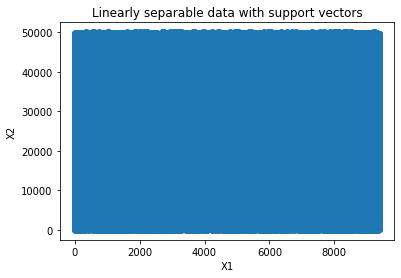

In [96]:
#visualize svm
# Get support vector indices
support_vector_indices = clf_dec.support_
print(support_vector_indices)
# Get number of support vectors per class
support_vectors_per_class = clf_dec.n_support_
print(support_vectors_per_class)
# Get support vectors themselves
support_vectors = clf_dec.support_vectors_

# Visualize support vectors
Train_X_Tfidf_dec_mtlb = Train_X_Tfidf_dec.todok()
xy = np.array(list(Train_X_Tfidf_dec_mtlb.keys()))
vals = np.array(list(Train_X_Tfidf_dec_mtlb.values()))

plt.scatter(xy[:,0], xy[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [31]:
# fit the training dataset on the classifier
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [2,3,5,7,9]
classifiers = []
for kern in kernels:
    start_time = time.time()
    if kern == 'poly':
        for deg in degrees:
            start_time = time.time()
            clf_result = OneClassSVM(gamma='auto', kernel=kern, degree=deg).fit(Train_X_Tfidf_dec)
            elapsed_time = time.time() - start_time
            classifiers.append([kern,deg,clf_result,elapsed_time])
            print('kernel used: ' , kern, ' degree used: ' , deg, ' elapsed_time:' , elapsed_time)
            
    else:
        clf_result = OneClassSVM(gamma='auto', kernel=kern).fit(Train_X_Tfidf_dec)
        elapsed_time = time.time() - start_time
        classifiers.append([kern,0,clf_result,elapsed_time])
        print('kernel used: ' , kern, ' elapsed_time: ' , elapsed_time)

# predict the labels on validation dataset

kernel used:  linear  elapsed_time:  206.0532670021057
kernel used:  poly  degree used:  2  elapsed_time: 116.00160336494446
kernel used:  poly  degree used:  3  elapsed_time: 117.60380554199219
kernel used:  poly  degree used:  5  elapsed_time: 120.63960981369019
kernel used:  poly  degree used:  7  elapsed_time: 115.24142622947693
kernel used:  poly  degree used:  9  elapsed_time: 110.39272284507751
kernel used:  rbf  elapsed_time:  224.16166996955872
kernel used:  sigmoid  elapsed_time:  198.15552282333374


In [32]:
clas_result = []
for clas in classifiers:
    start_time = time.time()
    predict_result = clas[2].predict(Test_X_Tfidf_dec)
    elapsed_time = time.time() - start_time
    clas_result.append([clas[0],clas[1],clas[2],predict_result])
    acc = accuracy_score(predict_result*-1, Test_X_oc_all['label'], normalize=True)
    print('kernel used: ' , clas[0], ' degree used:' , clas[1], ' elapsed_time: ' , elapsed_time, ' accuracy: ', acc)
            

# predict the labels on validation dataset

kernel used:  linear  degree used: 0  elapsed_time:  527.5232949256897  accuracy:  0.47098639679306037
kernel used:  poly  degree used: 2  elapsed_time:  583.4301912784576  accuracy:  0.8648003329609428
kernel used:  poly  degree used: 3  elapsed_time:  576.8514728546143  accuracy:  0.8651289128387111
kernel used:  poly  degree used: 5  elapsed_time:  560.3537075519562  accuracy:  0.8662898950734924
kernel used:  poly  degree used: 7  elapsed_time:  471.34412693977356  accuracy:  0.8661803684475696
kernel used:  poly  degree used: 9  elapsed_time:  447.4061143398285  accuracy:  0.8661694157849773
kernel used:  rbf  degree used: 0  elapsed_time:  418.39241909980774  accuracy:  0.4737355151037217
kernel used:  sigmoid  degree used: 0  elapsed_time:  411.02926230430603  accuracy:  0.47299073404744696
